In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!pip install mtcnn

In [34]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [35]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()

In [36]:
img = cv.imread('/content/drive/MyDrive/Project2566/Test_Face_Recognition/Face/dataset_EC_300/17_Bunyakorn/10.jpg')
# opencv BGR channel format and plt reads images as RGB channel format

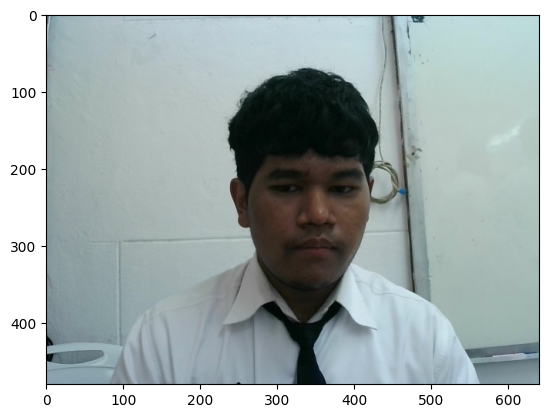

In [37]:
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) # RGB

In [38]:
results = detector.detect_faces(img)

1/1 [==============================] - 0s 125ms/step


In [39]:
results

[{'box': [255, 151, 161, 202],
  'confidence': 0.9999947547912598,
  'keypoints': {'left_eye': (312, 222),
   'right_eye': (386, 223),
   'nose': (354, 264),
   'mouth_left': (317, 305),
   'mouth_right': (379, 305)}}]

In [40]:
x,y,w,h = results[0]['box']

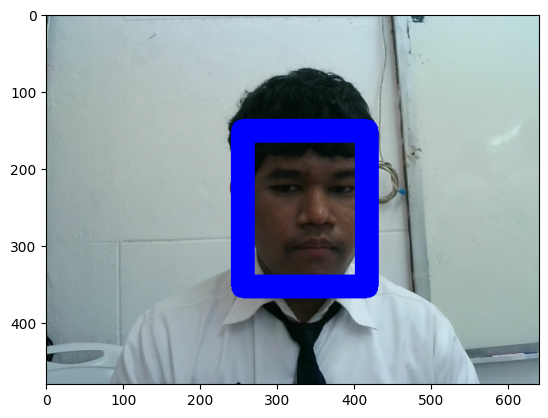

In [41]:
img = cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 30)
plt.imshow(img)

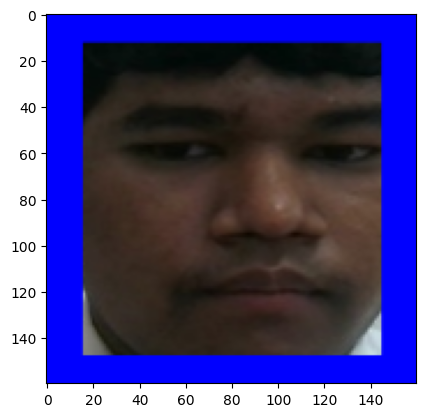

In [42]:
my_face = img[y:y+h, x:x+w]
#Facenet takes as input 160x160
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

In [43]:
my_face

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]

# Automate the preprocessing


In [44]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.cnt = 0
        self.detector = MTCNN()

    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr


    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            self.cnt = self.cnt + 1
            print("Count : " + str(self.cnt))
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [45]:
faceloading = FACELOADING("/content/drive/MyDrive/Project2566/Test_Face_Recognition/Face/dataset_EC_300/")
X, Y = faceloading.load_classes()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
Count : 32
Loaded successfully: 345
1/1 [==============================] - 0s 18ms/step
Count : 33
Loaded successfully: 345


In [ ]:
 '''
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 40
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')
  '''

KeyboardInterrupt: ignored

*italicized text*# FaceNet part

In [47]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10369 sha256=0f03cf3b05fa63a2553460d0a16e56c321d62235f39e1357352042352466a6a5
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [48]:
!pip install keras_facenet

from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0)
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [49]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 33ms/step


In [50]:
np.savez_compressed('faces_embeddings_test_EC(300).npz', EMBEDDED_X, Y)

# SVM model

In [51]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Text(0, 0.5, '1')

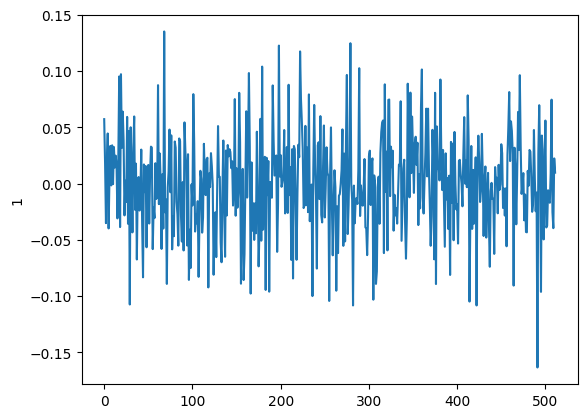

In [52]:
plt.plot(EMBEDDED_X[0])
plt.ylabel(Y[0])

In [53]:
Y

array([ 1,  1,  1, ..., 32, 32, 32])

In [54]:
from sklearn.model_selection import train_test_split

#X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)
X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, random_state=17, test_size=0.15, shuffle=True)

In [55]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [56]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [57]:
from sklearn.metrics import accuracy_score, classification_report

accuracy_score(Y_train, ypreds_train)

classification_rep = classification_report(Y_train, ypreds_train)

print(f'Accuracy: {accuracy_score}')
print(classification_rep)

Accuracy: <function accuracy_score at 0x78e07895bd90>
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       296
           1       1.00      1.00      1.00       287
           2       1.00      1.00      1.00       290
           3       1.00      1.00      1.00       298
           4       1.00      1.00      1.00       299
           5       1.00      1.00      1.00       289
           6       1.00      1.00      1.00       299
           7       1.00      1.00      1.00       294
           8       1.00      1.00      1.00       286
           9       1.00      1.00      1.00       280
          10       1.00      1.00      1.00       299
          11       1.00      1.00      1.00       289
          12       1.00      1.00      1.00       306
          13       0.99      1.00      1.00       305
          14       1.00      1.00      1.00       277
          15       1.00      0.99      1.00       288
          16       1.00    

In [58]:
accuracy_score(Y_train,ypreds_train)

0.999169348977261

#Test Predict Bunyakorn

In [ ]:
"""
t_im = cv.imread("/content/drive/MyDrive/Project2566/Test_Face_Recognition/Test_Folder/test.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']
"""

In [ ]:
"""
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)
"""

In [ ]:
"""t
est_im = [test_im]
ypreds = model.predict(test_im)
"""

In [ ]:
#ypreds

In [ ]:
"""
img_show = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
plt.imshow(img_show) # RGB
encoder.inverse_transform(ypreds)
"""

#Test Predict PUN

In [ ]:
"""
t_im = cv.imread("/content/drive/MyDrive/Project2566/Test_Face_Recognition/Test_Folder/Test_PUN.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']
"""

In [ ]:
"""
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)
"""

In [ ]:
"""
test_im = [test_im]
ypreds = model.predict(test_im)
"""

In [ ]:
#ypreds

In [ ]:
"""
img_show = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
plt.imshow(img_show) # RGB
encoder.inverse_transform(ypreds)
"""

#Test Predict TonChat

In [ ]:
"""
t_im = cv.imread("/content/drive/MyDrive/Project2566/Test_Face_Recognition/Test_Folder/ton_Chat_test.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

test_im = [test_im]
ypreds = model.predict(test_im)

ypreds

img_show = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
plt.imshow(img_show) # RGB
encoder.inverse_transform(ypreds)
"""

#Test Predict TonKit

In [ ]:
"""
t_im = cv.imread("/content/drive/MyDrive/Project2566/Test_Face_Recognition/Test_Folder/ton_kit_test.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

test_im = [test_im]
ypreds = model.predict(test_im)

ypreds

img_show = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
plt.imshow(img_show) # RGB
encoder.inverse_transform(ypreds)
"""

#PREDICT ALL

In [ ]:
'''
path = '/content/drive/MyDrive/Project2566/Test_Face_Recognition/Valid_Test/'
#t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
#x,y,w,h = detector.detect_faces(t_im)[0]['box']

#t_im = t_im[y:y+h, x:x+w]
#t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

test_im = [test_im]
ypreds = model.predict(test_im)

ypreds

#img_show = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
plt.imshow(img_show) # RGB
encoder.inverse_transform(ypreds)
'''

#Import Model

In [59]:
import pickle
#save the model
with open('svm_model_EC_160x160(300).pkl','wb') as f:
    pickle.dump(model,f)